In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_groups = [
    ['Testis'],
    ['Ovary'],
    ['Cells_EBV-transformed_lymphocytes'],
    [
        'Brain_Caudate_basal_ganglia',
        'Brain_Cerebellar_Hemisphere',
        'Brain_Cortex',
        'Brain_Frontal_Cortex_BA9',
    ],
]

basic_tissues = [
    'Testis',
    'Ovary',
    'Cells_EBV-transformed_lymphocytes',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
]

basic_tissue_dict = {t : i for i, t in enumerate(basic_tissues)}

tissue_scalers = [
    None,
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]

tissue_scales = [
    0.,
    0.05,
    0.15,
    0.05,
    0.05,
]

correct_tissue_scalers = [
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]


In [3]:

version_suffix = '_lead_aparent'


In [4]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

spearman_rs = np.zeros((len(basic_tissues), len(tissue_scalers)))

correct_spearman_rs = []

blacklist_ids = [
    'chr5_76728085_C_T'
]

for tissue_ix, tissue_type in enumerate(basic_tissues) :
    
    for scaler_ix in range(len(tissue_scalers)) :

        snp_pred_df = pd.read_csv("predictions/apa_gtex_data/human_convnet_16_16_no_dense_linear_leslie_hek293_testis_bootstrap_predictions_pred_df.csv", sep='\t')
        snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

        snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

        snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

        if tissue_scalers[scaler_ix] is not None :
            ensemble_df = pd.read_csv("predictions/apa_gtex_data/" + tissue_scalers[scaler_ix] + "_predictions_pred_df.csv", sep='\t').query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

            snp_pred_df['ref_tissue_score_1'] = ensemble_df['ref_tissue_score_1']
            snp_pred_df['ref_tissue_score_2'] = ensemble_df['ref_tissue_score_2']
            snp_pred_df['var_tissue_score_1'] = ensemble_df['var_tissue_score_1']
            snp_pred_df['var_tissue_score_2'] = ensemble_df['var_tissue_score_2']
        else :
            snp_pred_df['ref_tissue_score_1'] = 0.
            snp_pred_df['ref_tissue_score_2'] = 0.
            snp_pred_df['var_tissue_score_1'] = 0.
            snp_pred_df['var_tissue_score_2'] = 0.

        #snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * ((snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1']) + (snp_pred_df['ref_tissue_score_2'] - snp_pred_df['ref_tissue_score_1'])) / 2.
        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * (snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1'])

        #PDUI
        snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
        snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

        snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

        lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

        lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

        lead_snp_pred_df_backup = lead_snp_pred_df

        filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

        filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

        y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
        y_true = np.ravel(np.array(filtered_df['effect_size'].values))

        spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)

        spearman_rs[tissue_ix, scaler_ix] = spearman_r_val
        
        if tissue_scalers[scaler_ix] == correct_tissue_scalers[tissue_ix] :
            correct_spearman_rs.append(spearman_r_val)


In [5]:

suffix = '_argmax'


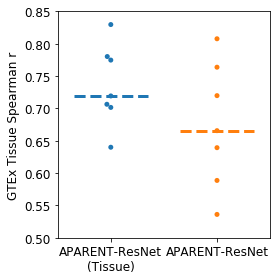

In [6]:
#Compare predictor r-values

import seaborn as sns

f = plt.figure(figsize=(4, 4))

ax = sns.swarmplot(data=[correct_spearman_rs, spearman_rs[:, 0]])

r_medians = [np.median(correct_spearman_rs), np.median(spearman_rs[:, 0])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, r_m in enumerate(r_medians) :
    plt.plot([i - 0.35, i + 0.35], [r_m, r_m], linewidth=3, linestyle="--", color=colors[i])

plt.xticks([0, 1], ['APARENT-ResNet\n(Tissue)', 'APARENT-ResNet'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0.5, .85)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.eps")

plt.show()


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


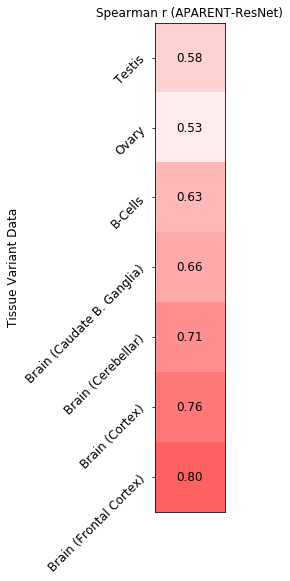

In [7]:

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain (Caudate B. Ganglia)', 'Brain (Cerebellar)', 'Brain (Cortex)', 'Brain (Frontal Cortex)']

f = plt.figure(figsize=(2, 9))

plt.imshow(spearman_rs[:, 0][:, None], cmap="bwr", vmin=0., vmax=1., aspect='equal')

for i in range(spearman_rs.shape[0]) :
    spearm_str = str(spearman_rs[:, 0][:, None][i, 0])[:4]
    text = plt.gca().text(0, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks([], [])
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("Spearman r (APARENT-ResNet)", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_baseline_heatmap" + suffix + ".png", dpi=300)
plt.savefig("apa_resnet_tissue_baseline_heatmap" + suffix + ".eps")

plt.show()


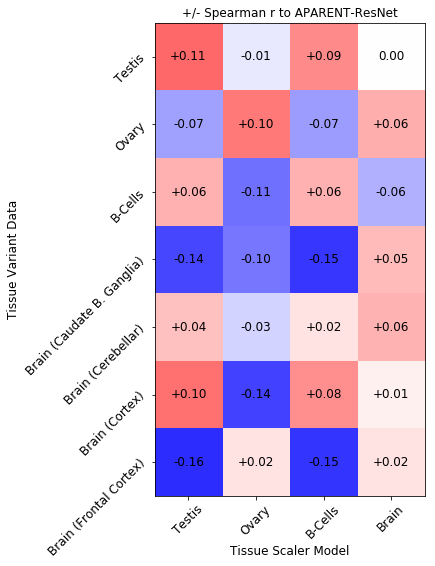

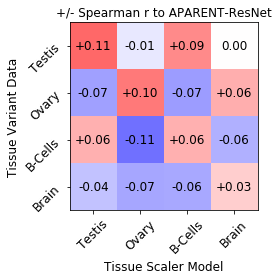

In [8]:
#Expanded Brain Tissues

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain (Caudate B. Ganglia)', 'Brain (Cerebellar)', 'Brain (Cortex)', 'Brain (Frontal Cortex)']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(8, 8))

plt.imshow(spearman_rs[:, 1:] - spearman_rs[:, 0][:, None], cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs.shape[0]) :
    for j in range(spearman_rs.shape[1] - 1) :
        
        spearm_str = str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.eps")

plt.show()

#Collapsed Brain Tissues

spearman_rs_collapsed = spearman_rs[:, 1:] - spearman_rs[:, 0][:, None]
spearman_rs_collapsed[3:, :] = np.median(spearman_rs_collapsed[3:, :], axis=0)
spearman_rs_collapsed = spearman_rs_collapsed[:4, :]

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(4, 4))

plt.imshow(spearman_rs_collapsed, cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs_collapsed.shape[0]) :
    for j in range(spearman_rs_collapsed.shape[1]) :
        
        spearm_str = str(spearman_rs_collapsed[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str(spearman_rs_collapsed[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.eps")

plt.show()


In [9]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

tissue_scale_range = np.linspace(0.0, 0.25, 11).tolist()#np.linspace(0.0, 0.2, 21).tolist()

spearman_rs = np.zeros((len(tissue_scale_range), len(basic_tissues), len(tissue_scalers)))

blacklist_ids = [
    'chr5_76728085_C_T'
]

for tissue_scale_ix, tissue_scale in enumerate(tissue_scale_range) :

    for tissue_ix, tissue_type in enumerate(basic_tissues) :

        for scaler_ix in range(len(tissue_scalers)) :

            snp_pred_df = pd.read_csv("predictions/apa_gtex_data/human_convnet_16_16_no_dense_linear_leslie_hek293_testis_bootstrap_predictions_pred_df.csv", sep='\t')
            snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

            snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)

            snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105

            if tissue_scalers[scaler_ix] is not None :
                ensemble_df = pd.read_csv("predictions/apa_gtex_data/" + tissue_scalers[scaler_ix] + "_predictions_pred_df.csv", sep='\t').query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)

                snp_pred_df['ref_tissue_score_1'] = ensemble_df['ref_tissue_score_1']
                snp_pred_df['ref_tissue_score_2'] = ensemble_df['ref_tissue_score_2']
                snp_pred_df['var_tissue_score_1'] = ensemble_df['var_tissue_score_1']
                snp_pred_df['var_tissue_score_2'] = ensemble_df['var_tissue_score_2']
            else :
                snp_pred_df['ref_tissue_score_1'] = 0.
                snp_pred_df['ref_tissue_score_2'] = 0.
                snp_pred_df['var_tissue_score_1'] = 0.
                snp_pred_df['var_tissue_score_2'] = 0.

            #snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * ((snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1']) + (snp_pred_df['ref_tissue_score_2'] - snp_pred_df['ref_tissue_score_1'])) / 2.
            snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scale * (snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1'])

            #PDUI
            snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
            snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']

            snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

            snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

            lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

            lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
            lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')

            lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

            lead_snp_pred_df_backup = lead_snp_pred_df

            filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")# and site_type == '3_most_exon'

            filtered_df = filtered_df.loc[~filtered_df['snp_id'].isin(blacklist_ids)]

            y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
            y_true = np.ravel(np.array(filtered_df['effect_size'].values))

            spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)

            spearman_rs[tissue_scale_ix, tissue_ix, scaler_ix] = spearman_r_val


In [10]:

spearman_rs = spearman_rs[:, :, 1:] - spearman_rs[:, :, 0][:, :, None]
spearman_rs[:, 3:, :] = np.median(spearman_rs[:, 3:, :], axis=1)[:, None, :]
spearman_rs = spearman_rs[:, :4, :]


In [11]:

spearman_r_intended = spearman_rs[:, np.arange(4), np.arange(4)]


In [12]:

off_diag = {
    0 : [1, 2, 3],
    1 : [0, 2, 3],
    2 : [0, 1, 3],
    3 : [0, 1, 2]
}

spearman_r_unintended_per_scaler = np.zeros((len(tissue_scale_range), 4))
spearman_r_unintended_per_tissue = np.zeros((len(tissue_scale_range), 4))

for tissue_scale_ix, tissue_scale in enumerate(tissue_scale_range) :
    
    for scaler_ix in range(4) :
        
        spearman_r_unintended_per_scaler[tissue_scale_ix, scaler_ix] = np.mean(spearman_rs[tissue_scale_ix, off_diag[scaler_ix], scaler_ix])
        spearman_r_unintended_per_tissue[tissue_scale_ix, scaler_ix] = np.mean(spearman_rs[tissue_scale_ix, scaler_ix, off_diag[scaler_ix]])


In [13]:

spearman_r_argmax = np.argmax(spearman_r_intended, axis=0)


In [14]:

spearman_r_argmax = np.unique(np.array([tissue_scale_range[spearman_r_argmax[j]] for j in range(4)]))


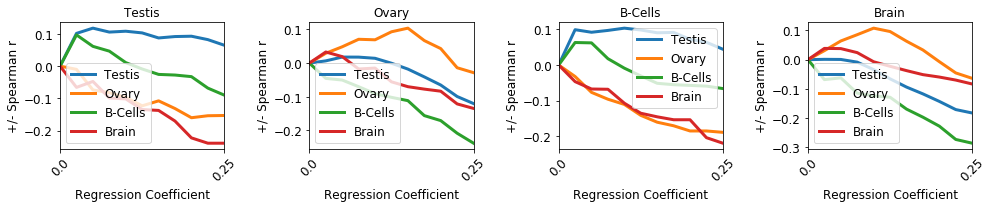

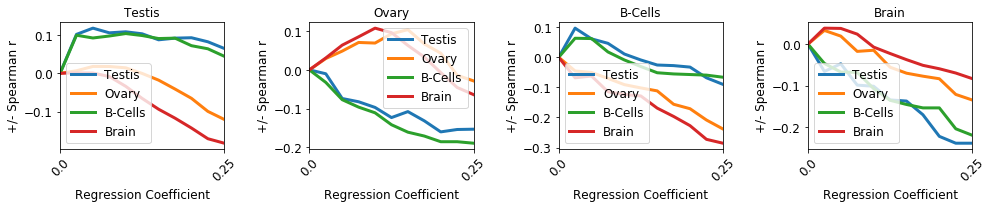

In [15]:

f, axs = plt.subplots(1, 4, figsize=(4 * 3.5, 3))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for scaler_ix, scaler in enumerate(tissues) :
    
    ls = []
    for tissue_ix, tissue in enumerate(tissues) :
        l1, = axs[scaler_ix].plot(tissue_scale_range, spearman_rs[:, tissue_ix, scaler_ix], linewidth=3, color=colors[tissue_ix], label=tissue)
        ls.append(l1)
    
    plt.sca(axs[scaler_ix])

    plt.xlim(tissue_scale_range[0], tissue_scale_range[-1])

    plt.xticks([tissue_scale_range[0], tissue_scale_range[-1]], [tissue_scale_range[0], tissue_scale_range[-1]], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    plt.xlabel("Regression Coefficient", fontsize=12)
    plt.ylabel("+/- Spearman r", fontsize=12)
    
    plt.title(scaler, fontsize=12)

    plt.legend(handles=ls, fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scale_coeff_control_per_scaler_detailed" + suffix + ".png", dpi=300)
plt.savefig("apa_resnet_tissue_scale_coeff_control_per_scaler_detailed" + suffix + ".eps")

plt.show()

f, axs = plt.subplots(1, 4, figsize=(4 * 3.5, 3))

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for tissue_ix, tissue in enumerate(tissues) :
    
    ls = []
    for scaler_ix, scaler in enumerate(tissues) :
        l1, = axs[tissue_ix].plot(tissue_scale_range, spearman_rs[:, tissue_ix, scaler_ix], linewidth=3, color=colors[scaler_ix], label=scaler)
        ls.append(l1)
    
    plt.sca(axs[tissue_ix])

    plt.xlim(tissue_scale_range[0], tissue_scale_range[-1])

    plt.xticks([tissue_scale_range[0], tissue_scale_range[-1]], [tissue_scale_range[0], tissue_scale_range[-1]], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    plt.xlabel("Regression Coefficient", fontsize=12)
    plt.ylabel("+/- Spearman r", fontsize=12)
    
    plt.title(tissue, fontsize=12)

    plt.legend(handles=ls, fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scale_coeff_control_per_tissue_detailed" + suffix + ".png", dpi=300)
plt.savefig("apa_resnet_tissue_scale_coeff_control_per_tissue_detailed" + suffix + ".eps")

plt.show()


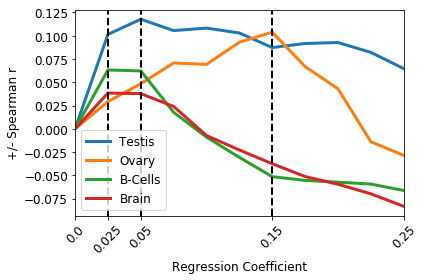

In [16]:

f = plt.figure(figsize=(6, 4))

ls = []
for j in range(4) :
    l1, = plt.plot(tissue_scale_range, spearman_r_intended[:, j], linewidth=3, label=tissues[j])
    ls.append(l1)

for j in range(spearman_r_argmax.shape[0]) :
    plt.axvline(x=spearman_r_argmax[j], linewidth=2, linestyle='--', color='black')

plt.xlim(tissue_scale_range[0], tissue_scale_range[-1])

plt.xticks([tissue_scale_range[0]] + spearman_r_argmax.tolist() + [tissue_scale_range[-1]], [tissue_scale_range[0]] + np.round(spearman_r_argmax, 3).tolist() + [tissue_scale_range[-1]], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.xlabel("Regression Coefficient", fontsize=12)
plt.ylabel("+/- Spearman r", fontsize=12)

plt.legend(handles=ls, fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scale_coeff" + suffix + ".png", dpi=300)
plt.savefig("apa_resnet_tissue_scale_coeff" + suffix + ".eps")

plt.show()


In [15]:
#Load tissue pair correlations from aQTL Nature Genetics paper

gtex_corr_df = pd.read_csv("mashR_figure2b_matrix.txt", sep='\t')


In [17]:
#Construct data matrix

gtex_corr_tissue_dict = {}

i = 0
for gtex_corr_tissue_1, row in gtex_corr_df.iterrows() :
    
    gtex_corr_tissue_dict[gtex_corr_tissue_1] = i
    
    i += 1

gtex_corr = np.zeros((len(gtex_corr_df), len(gtex_corr_df)))

for gtex_corr_tissue_1, row in gtex_corr_df.iterrows() :
    
    gtex_corr_tissue_1_ix = gtex_corr_tissue_dict[gtex_corr_tissue_1]
    
    for gtex_corr_tissue_2 in gtex_corr_df.columns.values.tolist() :
        
        gtex_corr_tissue_2_ix = gtex_corr_tissue_dict[gtex_corr_tissue_2]
        
        if not np.isnan(row[gtex_corr_tissue_2]) :
            gtex_corr[gtex_corr_tissue_1_ix, gtex_corr_tissue_2_ix] = row[gtex_corr_tissue_2]
        else :
            gtex_corr[gtex_corr_tissue_1_ix, gtex_corr_tissue_2_ix] = gtex_corr[gtex_corr_tissue_2_ix, gtex_corr_tissue_1_ix]


In [22]:
#Collapse/simplify correlation matrix

testis_ixs = [gtex_corr_tissue_dict['Testis']]
ovary_ixs = [gtex_corr_tissue_dict['Ovary']]
bcells_ixs = [gtex_corr_tissue_dict['Cells - EBV-transformed lymphocytes']]
brain_ixs = [gtex_corr_tissue_dict['Brain - Caudate (basal ganglia)'], gtex_corr_tissue_dict['Brain - Cerebellar Hemisphere'], gtex_corr_tissue_dict['Brain - Cortex'], gtex_corr_tissue_dict['Brain - Frontal Cortex (BA9)']]

gtex_corr_collapsed = np.zeros((4, 4))

gtex_corr_collapsed[0, 0] = np.median(gtex_corr[testis_ixs, testis_ixs])
gtex_corr_collapsed[0, 1] = np.median(gtex_corr[testis_ixs, ovary_ixs])
gtex_corr_collapsed[0, 2] = np.median(gtex_corr[testis_ixs, bcells_ixs])
gtex_corr_collapsed[0, 3] = np.median(gtex_corr[testis_ixs, brain_ixs])

gtex_corr_collapsed[1, 0] = np.median(gtex_corr[ovary_ixs, testis_ixs])
gtex_corr_collapsed[1, 1] = np.median(gtex_corr[ovary_ixs, ovary_ixs])
gtex_corr_collapsed[1, 2] = np.median(gtex_corr[ovary_ixs, bcells_ixs])
gtex_corr_collapsed[1, 3] = np.median(gtex_corr[ovary_ixs, brain_ixs])

gtex_corr_collapsed[2, 0] = np.median(gtex_corr[bcells_ixs, testis_ixs])
gtex_corr_collapsed[2, 1] = np.median(gtex_corr[bcells_ixs, ovary_ixs])
gtex_corr_collapsed[2, 2] = np.median(gtex_corr[bcells_ixs, bcells_ixs])
gtex_corr_collapsed[2, 3] = np.median(gtex_corr[bcells_ixs, brain_ixs])

gtex_corr_collapsed[3, 0] = np.median(gtex_corr[brain_ixs, testis_ixs])
gtex_corr_collapsed[3, 1] = np.median(gtex_corr[brain_ixs, ovary_ixs])
gtex_corr_collapsed[3, 2] = np.median(gtex_corr[brain_ixs, bcells_ixs])
gtex_corr_collapsed[3, 3] = np.median(gtex_corr[brain_ixs, brain_ixs])


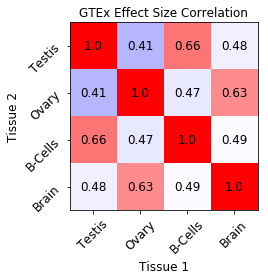

In [48]:

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(4, 4))

#vmin = np.min(gtex_corr_collapsed)
#vmax = np.max(gtex_corr_collapsed)
vmin = 0.2#np.min(gtex_corr)
vmax = 0.8#np.max(gtex_corr)

plt.imshow(gtex_corr_collapsed, cmap="bwr", vmin=vmin, vmax=vmax, aspect='equal')

for i in range(gtex_corr_collapsed.shape[0]) :
    for j in range(gtex_corr_collapsed.shape[1]) :
        
        spearm_str = str(gtex_corr_collapsed[i, j])[:4]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue 1", fontsize=12)
plt.ylabel("Tissue 2", fontsize=12)

plt.title("GTEx Effect Size Correlation", fontsize=12)

plt.tight_layout()

plt.savefig("apa_gtex_tissue_corr_heatmap" + suffix + ".png", dpi=300)
plt.savefig("apa_gtex_tissue_corr_heatmap" + suffix + ".eps")

plt.show()


In [46]:
#Analyze scaler training data tissue correlations

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Load data features

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_2_utr3_all_cuts.npz")

#Include cell types

included_cell_types = [
    #'leslie_count_hek293',
    'leslie_count_testis',
    'leslie_count_ovary',
    'leslie_count_blcl',
    'leslie_count_brain'
]

x, m, l, c, y, s = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

#Add extra singleton dim to x
x = np.expand_dims(x, axis=2)

#Shuffle c and y dimensions
c = np.transpose(c, (0, 2, 1))
y = np.transpose(y, (0, 2, 1))

#Slice celltypes

included_cell_type_ixs = [cell_type_dict[cell_type] for cell_type in included_cell_types]

cell_types = cell_types[included_cell_type_ixs]
c = c[:, included_cell_type_ixs, :]
y = y[:, included_cell_type_ixs, :]
s = s[:, included_cell_type_ixs]

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(s.shape))


x.shape = (6440, 10, 1, 205, 4)
m.shape = (6440, 10)
l.shape = (6440, 10)
c.shape = (6440, 4, 10)
y.shape = (6440, 4, 10)
s.shape = (6440, 4)


In [81]:
#Compute pari-wise correlations among tissues

spearman_r_vals = np.zeros((4, 4))

for i in range(4) :
    for j in range(4) :
        
        spearman_rs = []
        for k in range(10) :
            
            c1 = c[:, i, k]
            c2 = c[:, j, k]
            
            y1 = y[:, i, k]
            y2 = y[:, j, k]
            
            y1 = y1[(c1 > 10) & (c2 > 10)]
            y2 = y2[(c1 > 10) & (c2 > 10)]
            
            spearman_rs.append(spearmanr(y1, y2)[0])
        
        spearman_r_vals[i, j] = np.median(spearman_rs)


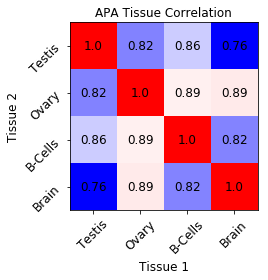

In [83]:

f = plt.figure(figsize=(4, 4))

vmin = np.min(spearman_r_vals)
vmax = np.max(spearman_r_vals)

plt.imshow(spearman_r_vals, cmap="bwr", vmin=vmin, vmax=vmax, aspect='equal')

for i in range(spearman_r_vals.shape[0]) :
    for j in range(spearman_r_vals.shape[1]) :
        
        spearm_str = str(spearman_r_vals[i, j])[:4]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue 1", fontsize=12)
plt.ylabel("Tissue 2", fontsize=12)

plt.title("APA Tissue Correlation", fontsize=12)

plt.tight_layout()

plt.savefig("apa_leslie_tissue_corr_heatmap" + suffix + ".png", dpi=300)
plt.savefig("apa_leslie_tissue_corr_heatmap" + suffix + ".eps")

plt.show()
